In [1]:
print(0)

0


# Importing Python Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
# image folder path
image_folder_path = "/home/pratyush/additional_work/Images"

# RGB image transformer specifications 
transform = transforms.Compose([
    # image size to 128, 128, 3
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),        
    # normalizinf it 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# loading the image dataset
dataset = datasets.ImageFolder(root=image_folder_path, transform=transform)

# train test split the data into train 70, test 20, and validation 10 percentege
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  
test_size = int(0.2 * dataset_size)   
val_size = dataset_size - train_size - test_size  

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# creating the dataloaders 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# class names
class_names = dataset.classes
num_classes = len(class_names) 

# one hot encoding the labels
images, labels = next(iter(train_loader))
one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()  

print("Train Batch Image Shape:", images.shape)  
print("Train Batch Labels Shape:", one_hot_labels.shape) 


Train Batch Image Shape: torch.Size([64, 3, 128, 128])
Train Batch Labels Shape: torch.Size([64, 21])


In [4]:
for i, j in train_loader:
    print(i.shape)
    print(j.shape)
    break
print(len(train_loader))

torch.Size([64, 3, 128, 128])
torch.Size([64])
23


In [5]:
for i, j in test_loader:
    print(i.shape)
    print(j.shape)
    break
print(len(test_loader))

torch.Size([64, 3, 128, 128])
torch.Size([64])
7


In [6]:
for i, j in val_loader:
    print(i.shape)
    print(j.shape)
    break
print(len(val_loader))

torch.Size([64, 3, 128, 128])
torch.Size([64])
4


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100

### Optimizaers to be considered
#### Adam
#### Adagrad
#### Adadelta
#### RMSProp
#### SGD with momentum

# Adam Optimizer

In [8]:
# loading the resnet 18 classifier
resnet18_adam = models.resnet18(pretrained=True)

# connecting 1000 neurons to 21 neurons 
num_features = resnet18_adam.fc.in_features
resnet18_adam.fc = nn.Linear(num_features, 21)  
resnet18_adam = resnet18_adam.to(device)

# using Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_adam.parameters(), lr=0.005)

# LR on plateau and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75, verbose=True)
early_stopping_patience = 10  
best_val_loss = float("inf")  
epochs_no_improve = 0  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# train and val loss and auc value
train_loss_adam_list = []
val_loss_adam_list = []
train_auc_adam_list = []
val_auc_adam_list = []

# training loop
for epoch in range(num_epochs):
    resnet18_adam.train()  
    train_loss = 0.0
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_adam(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)  
        all_train_probs.append(probs.detach().cpu().numpy()) 
        all_train_labels.append(labels.detach().cpu().numpy()) 

    train_loss /= len(train_loader)
    train_loss_adam_list.append(train_loss)
    all_train_labels = np.concatenate(all_train_labels)
    all_train_probs = np.concatenate(all_train_probs)
    try:
        train_auc = roc_auc_score(all_train_labels, all_train_probs, multi_class='ovr')
    except ValueError:
        train_auc = 0.0  

    train_auc_adam_list.append(train_auc)

    # validation phase
    resnet18_adam.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_adam(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            all_val_probs.append(probs.cpu().numpy())  
            all_val_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_adam_list.append(val_loss)
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs, multi_class='ovr')
    except ValueError:
        val_auc = 0.0  

    val_auc_adam_list.append(val_auc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    scheduler.step(val_loss)

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch [1/100] - Train Loss: 2.9375, Train AUC: 0.7120, Val Loss: 1560.9097, Val AUC: 0.4935
Epoch [2/100] - Train Loss: 2.2597, Train AUC: 0.8435, Val Loss: 4.3834, Val AUC: 0.7810
Epoch [3/100] - Train Loss: 2.0056, Train AUC: 0.8736, Val Loss: 2.8982, Val AUC: 0.8205
Epoch [4/100] - Train Loss: 1.6946, Train AUC: 0.9125, Val Loss: 1.9866, Val AUC: 0.9124
Epoch [5/100] - Train Loss: 1.4359, Train AUC: 0.9386, Val Loss: 1.8393, Val AUC: 0.9277
Epoch [6/100] - Train Loss: 1.3511, Train AUC: 0.9447, Val Loss: 1.5321, Val AUC: 0.9336
Epoch [7/100] - Train Loss: 1.0843, Train AUC: 0.9642, Val Loss: 1.6937, Val AUC: 0.9354
Epoch [8/100] - Train Loss: 0.9518, Train AUC: 0.9721, Val Loss: 1.6942, Val AUC: 0.9336
Epoch [9/100] - Train Loss: 0.9542, Train AUC: 0.9742, Val Loss: 2.6982, Val AUC: 0.8908
Epoch [10/100] - Train Loss: 0.8227, Train AUC: 0.9793, Val Loss: 1.4361, Val AUC: 0.9491
Epoch [11/100] - Train Loss: 0.7042, Train AUC: 0.9838, Val Loss: 1.8137, Val AUC: 0.9266
Epoch [12/100] -

# Adagrad Optimizer

In [10]:
# loading the resnet 18 classifier
resnet18_adagrad = models.resnet18(pretrained=True)

# connecting 1000 neurons to 21 neurons 
num_features = resnet18_adagrad.fc.in_features
resnet18_adagrad.fc = nn.Linear(num_features, 21)  
resnet18_adagrad = resnet18_adagrad.to(device)

# using Adagrad Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(resnet18_adagrad.parameters(), lr=0.005)

# LR on plateau and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75, verbose=True)
early_stopping_patience = 10  
best_val_loss = float("inf")  
epochs_no_improve = 0  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# train and val loss and auc value
train_loss_adagrad_list = []
val_loss_adagrad_list = []
train_auc_adagrad_list = []
val_auc_adagrad_list = []

# training loop
for epoch in range(num_epochs):
    resnet18_adagrad.train()  
    train_loss = 0.0
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_adagrad(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)  
        all_train_probs.append(probs.detach().cpu().numpy()) 
        all_train_labels.append(labels.detach().cpu().numpy()) 

    train_loss /= len(train_loader)
    train_loss_adagrad_list.append(train_loss)
    all_train_labels = np.concatenate(all_train_labels)
    all_train_probs = np.concatenate(all_train_probs)
    try:
        train_auc = roc_auc_score(all_train_labels, all_train_probs, multi_class='ovr')
    except ValueError:
        train_auc = 0.0  

    train_auc_adagrad_list.append(train_auc)

    # validation phase
    resnet18_adagrad.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_adagrad(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            all_val_probs.append(probs.cpu().numpy())  
            all_val_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_adagrad_list.append(val_loss)
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs, multi_class='ovr')
    except ValueError:
        val_auc = 0.0  

    val_auc_adagrad_list.append(val_auc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    scheduler.step(val_loss)

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch [1/100] - Train Loss: 2.4635, Train AUC: 0.8141, Val Loss: 2.0075, Val AUC: 0.8921
Epoch [2/100] - Train Loss: 1.0056, Train AUC: 0.9673, Val Loss: 1.4727, Val AUC: 0.9519
Epoch [3/100] - Train Loss: 0.3703, Train AUC: 0.9953, Val Loss: 0.6297, Val AUC: 0.9881
Epoch [4/100] - Train Loss: 0.1363, Train AUC: 0.9991, Val Loss: 0.4379, Val AUC: 0.9939
Epoch [5/100] - Train Loss: 0.0804, Train AUC: 0.9997, Val Loss: 0.4365, Val AUC: 0.9938
Epoch [6/100] - Train Loss: 0.0486, Train AUC: 0.9999, Val Loss: 0.4058, Val AUC: 0.9953
Epoch [7/100] - Train Loss: 0.0365, Train AUC: 0.9999, Val Loss: 0.7804, Val AUC: 0.9888
Epoch [8/100] - Train Loss: 0.0360, Train AUC: 0.9998, Val Loss: 0.3958, Val AUC: 0.9956
Epoch [9/100] - Train Loss: 0.0113, Train AUC: 1.0000, Val Loss: 0.3694, Val AUC: 0.9971
Epoch [10/100] - Train Loss: 0.0068, Train AUC: 1.0000, Val Loss: 0.3550, Val AUC: 0.9970
Epoch [11/100] - Train Loss: 0.0059, Train AUC: 1.0000, Val Loss: 0.3565, Val AUC: 0.9970
Epoch [12/100] - Tr

# Adadelta Optimizer

In [12]:
# loading the resnet 18 classifier
resnet18_adadelta = models.resnet18(pretrained=True)

# connecting 1000 neurons to 21 neurons 
num_features = resnet18_adadelta.fc.in_features
resnet18_adadelta.fc = nn.Linear(num_features, 21)  
resnet18_adadelta = resnet18_adadelta.to(device)

# using Adadelta Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(resnet18_adadelta.parameters(), lr=0.005)

# LR on plateau and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75, verbose=True)
early_stopping_patience = 10  
best_val_loss = float("inf")  
epochs_no_improve = 0  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# train and val loss and auc value
train_loss_adadelta_list = []
val_loss_adadelta_list = []
train_auc_adadelta_list = []
val_auc_adadelta_list = []

# training loop
for epoch in range(num_epochs):
    resnet18_adadelta.train()  
    train_loss = 0.0
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_adadelta(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)  
        all_train_probs.append(probs.detach().cpu().numpy()) 
        all_train_labels.append(labels.detach().cpu().numpy()) 

    train_loss /= len(train_loader)
    train_loss_adadelta_list.append(train_loss)
    all_train_labels = np.concatenate(all_train_labels)
    all_train_probs = np.concatenate(all_train_probs)
    try:
        train_auc = roc_auc_score(all_train_labels, all_train_probs, multi_class='ovr')
    except ValueError:
        train_auc = 0.0  

    train_auc_adadelta_list.append(train_auc)

    # validation phase
    resnet18_adadelta.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_adadelta(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            all_val_probs.append(probs.cpu().numpy())  
            all_val_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_adadelta_list.append(val_loss)
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs, multi_class='ovr')
    except ValueError:
        val_auc = 0.0  

    val_auc_adadelta_list.append(val_auc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    scheduler.step(val_loss)

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch [1/100] - Train Loss: 3.0969, Train AUC: 0.6006, Val Loss: 2.8094, Val AUC: 0.7083
Epoch [2/100] - Train Loss: 2.6186, Train AUC: 0.7913, Val Loss: 2.4400, Val AUC: 0.8310
Epoch [3/100] - Train Loss: 2.1944, Train AUC: 0.9020, Val Loss: 2.0982, Val AUC: 0.9006
Epoch [4/100] - Train Loss: 1.8238, Train AUC: 0.9560, Val Loss: 1.8140, Val AUC: 0.9400
Epoch [5/100] - Train Loss: 1.5167, Train AUC: 0.9797, Val Loss: 1.5787, Val AUC: 0.9610
Epoch [6/100] - Train Loss: 1.2752, Train AUC: 0.9893, Val Loss: 1.3855, Val AUC: 0.9727
Epoch [7/100] - Train Loss: 1.0872, Train AUC: 0.9935, Val Loss: 1.2417, Val AUC: 0.9799
Epoch [8/100] - Train Loss: 0.9251, Train AUC: 0.9968, Val Loss: 1.1184, Val AUC: 0.9838
Epoch [9/100] - Train Loss: 0.7893, Train AUC: 0.9976, Val Loss: 1.0178, Val AUC: 0.9870
Epoch [10/100] - Train Loss: 0.6844, Train AUC: 0.9987, Val Loss: 0.9304, Val AUC: 0.9893
Epoch [11/100] - Train Loss: 0.5976, Train AUC: 0.9990, Val Loss: 0.8569, Val AUC: 0.9907
Epoch [12/100] - Tr

# RMS-Prop Optimizer

In [14]:
# loading the resnet 18 classifier
resnet18_rmsprop = models.resnet18(pretrained=True)

# connecting 1000 neurons to 21 neurons 
num_features = resnet18_rmsprop.fc.in_features
resnet18_rmsprop.fc = nn.Linear(num_features, 21)  
resnet18_rmsprop = resnet18_rmsprop.to(device)

# using rmsprop Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(resnet18_rmsprop.parameters(), lr=0.005)

# LR on plateau and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75, verbose=True)
early_stopping_patience = 10  
best_val_loss = float("inf")  
epochs_no_improve = 0  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# train and val loss and auc value
train_loss_rmsprop_list = []
val_loss_rmsprop_list = []
train_auc_rmsprop_list = []
val_auc_rmsprop_list = []

# training loop
for epoch in range(num_epochs):
    resnet18_rmsprop.train()  
    train_loss = 0.0
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_rmsprop(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)  
        all_train_probs.append(probs.detach().cpu().numpy()) 
        all_train_labels.append(labels.detach().cpu().numpy()) 

    train_loss /= len(train_loader)
    train_loss_rmsprop_list.append(train_loss)
    all_train_labels = np.concatenate(all_train_labels)
    all_train_probs = np.concatenate(all_train_probs)
    try:
        train_auc = roc_auc_score(all_train_labels, all_train_probs, multi_class='ovr')
    except ValueError:
        train_auc = 0.0  

    train_auc_rmsprop_list.append(train_auc)

    # validation phase
    resnet18_rmsprop.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_rmsprop(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            all_val_probs.append(probs.cpu().numpy())  
            all_val_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_rmsprop_list.append(val_loss)
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs, multi_class='ovr')
    except ValueError:
        val_auc = 0.0  

    val_auc_rmsprop_list.append(val_auc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    scheduler.step(val_loss)

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch [1/100] - Train Loss: 5.2893, Train AUC: 0.5003, Val Loss: 3.2342, Val AUC: 0.6008
Epoch [2/100] - Train Loss: 3.1396, Train AUC: 0.6019, Val Loss: 3.4138, Val AUC: 0.6691
Epoch [3/100] - Train Loss: 2.8460, Train AUC: 0.6835, Val Loss: 3.2835, Val AUC: 0.6828
Epoch [4/100] - Train Loss: 2.6058, Train AUC: 0.7575, Val Loss: 2.6700, Val AUC: 0.8030
Epoch [5/100] - Train Loss: 2.4281, Train AUC: 0.8018, Val Loss: 2.7309, Val AUC: 0.8027
Epoch [6/100] - Train Loss: 2.2391, Train AUC: 0.8333, Val Loss: 2.4152, Val AUC: 0.8477
Epoch [7/100] - Train Loss: 2.0692, Train AUC: 0.8589, Val Loss: 2.4608, Val AUC: 0.8410
Epoch [8/100] - Train Loss: 2.0280, Train AUC: 0.8672, Val Loss: 3.7306, Val AUC: 0.8319
Epoch [9/100] - Train Loss: 1.7883, Train AUC: 0.8982, Val Loss: 2.0261, Val AUC: 0.8876
Epoch [10/100] - Train Loss: 1.7544, Train AUC: 0.9043, Val Loss: 1.9855, Val AUC: 0.8878
Epoch [11/100] - Train Loss: 1.5968, Train AUC: 0.9204, Val Loss: 2.3218, Val AUC: 0.8657
Epoch [12/100] - Tr

# SGD with Momentum Oprimizer

In [16]:
# loading the resnet 18 classifier
resnet18_sgd = models.resnet18(pretrained=True)

# connecting 1000 neurons to 21 neurons 
num_features = resnet18_sgd.fc.in_features
resnet18_sgd.fc = nn.Linear(num_features, 21)  
resnet18_sgd = resnet18_sgd.to(device)

# using sgd Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_sgd.parameters(), lr=0.005)

# LR on plateau and early stopping
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.75, verbose=True)
early_stopping_patience = 10  
best_val_loss = float("inf")  
epochs_no_improve = 0  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# train and val loss and auc value
train_loss_sgd_list = []
val_loss_sgd_list = []
train_auc_sgd_list = []
val_auc_sgd_list = []

# training loop
for epoch in range(num_epochs):
    resnet18_sgd.train()  
    train_loss = 0.0
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_sgd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = F.softmax(outputs, dim=1)  
        all_train_probs.append(probs.detach().cpu().numpy()) 
        all_train_labels.append(labels.detach().cpu().numpy()) 

    train_loss /= len(train_loader)
    train_loss_sgd_list.append(train_loss)
    all_train_labels = np.concatenate(all_train_labels)
    all_train_probs = np.concatenate(all_train_probs)
    try:
        train_auc = roc_auc_score(all_train_labels, all_train_probs, multi_class='ovr')
    except ValueError:
        train_auc = 0.0  

    train_auc_sgd_list.append(train_auc)

    # validation phase
    resnet18_sgd.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_sgd(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            all_val_probs.append(probs.cpu().numpy())  
            all_val_labels.append(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_sgd_list.append(val_loss)
    all_val_labels = np.concatenate(all_val_labels)
    all_val_probs = np.concatenate(all_val_probs)
    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs, multi_class='ovr')
    except ValueError:
        val_auc = 0.0  

    val_auc_sgd_list.append(val_auc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    scheduler.step(val_loss)

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch [1/100] - Train Loss: 2.8002, Train AUC: 0.7035, Val Loss: 2.2766, Val AUC: 0.8858
Epoch [2/100] - Train Loss: 1.8288, Train AUC: 0.9497, Val Loss: 1.6549, Val AUC: 0.9712
Epoch [3/100] - Train Loss: 1.2445, Train AUC: 0.9871, Val Loss: 1.2264, Val AUC: 0.9858
Epoch [4/100] - Train Loss: 0.8523, Train AUC: 0.9957, Val Loss: 0.9366, Val AUC: 0.9909
Epoch [5/100] - Train Loss: 0.6343, Train AUC: 0.9978, Val Loss: 0.7588, Val AUC: 0.9937
Epoch [6/100] - Train Loss: 0.4821, Train AUC: 0.9990, Val Loss: 0.6425, Val AUC: 0.9949
Epoch [7/100] - Train Loss: 0.3733, Train AUC: 0.9994, Val Loss: 0.5606, Val AUC: 0.9959
Epoch [8/100] - Train Loss: 0.3150, Train AUC: 0.9997, Val Loss: 0.5030, Val AUC: 0.9964
Epoch [9/100] - Train Loss: 0.2423, Train AUC: 0.9999, Val Loss: 0.4591, Val AUC: 0.9968
Epoch [10/100] - Train Loss: 0.2030, Train AUC: 0.9999, Val Loss: 0.4307, Val AUC: 0.9970
Epoch [11/100] - Train Loss: 0.1871, Train AUC: 0.9999, Val Loss: 0.4025, Val AUC: 0.9971
Epoch [12/100] - Tr

# Plotting

In [18]:
def plot_training_curves(train_loss, val_loss, train_auc, val_auc, optimizer_name):
    epochs = range(1, len(train_loss) + 1)  

    # loss curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label="Train Loss")  
    plt.plot(epochs, val_loss, 'orange', label="Val Loss")  
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(optimizer_name+"-Loss Curve")
    plt.legend()

    # AUC-ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_auc, 'b-', label="Train AUC")  
    plt.plot(epochs, val_auc, 'orange', label="Val AUC")  
    plt.xlabel("Epochs")
    plt.ylabel("AUC-ROC")
    plt.title(optimizer_name+"-AUC-ROC Curve")
    plt.legend()

    plt.show()

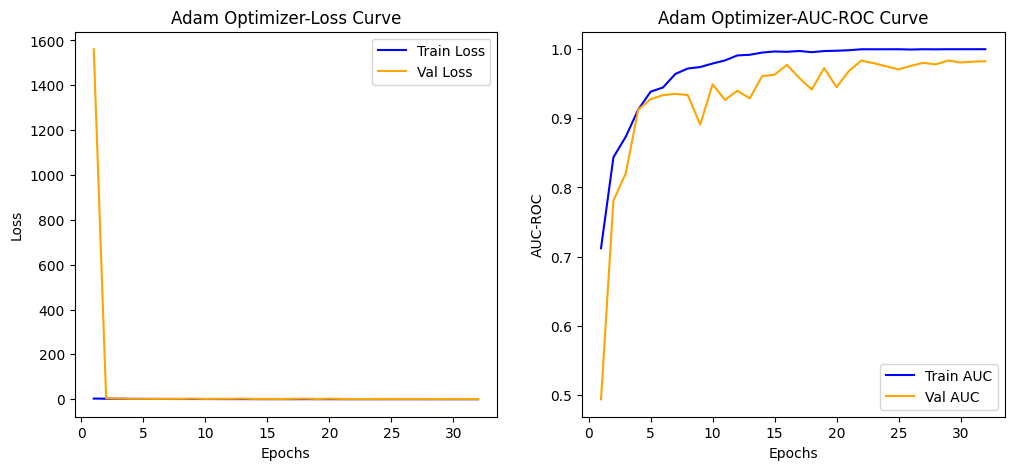

In [19]:
plot_training_curves(train_loss_adam_list, val_loss_adam_list, train_auc_adam_list, val_auc_adam_list, "Adam Optimizer")

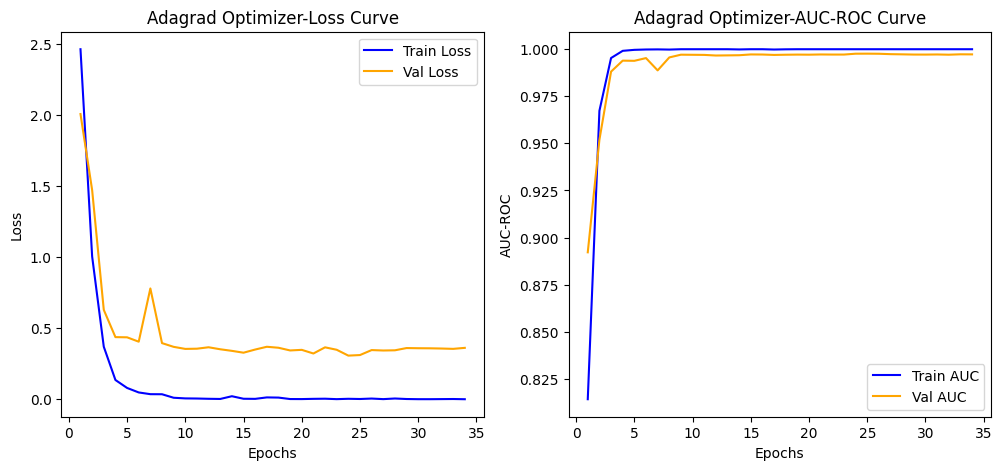

In [20]:
plot_training_curves(train_loss_adagrad_list, val_loss_adagrad_list, train_auc_adagrad_list, val_auc_adagrad_list, "Adagrad Optimizer")

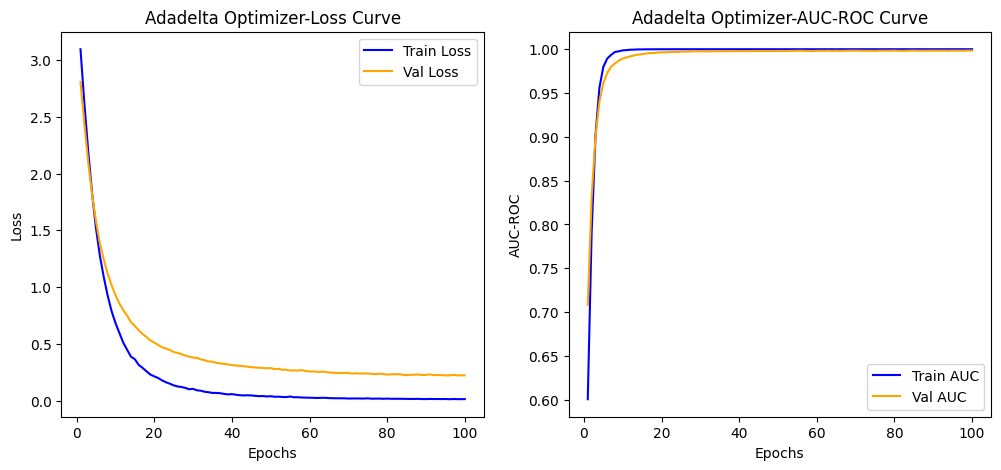

In [21]:
plot_training_curves(train_loss_adadelta_list, val_loss_adadelta_list, train_auc_adadelta_list, val_auc_adadelta_list, "Adadelta Optimizer")

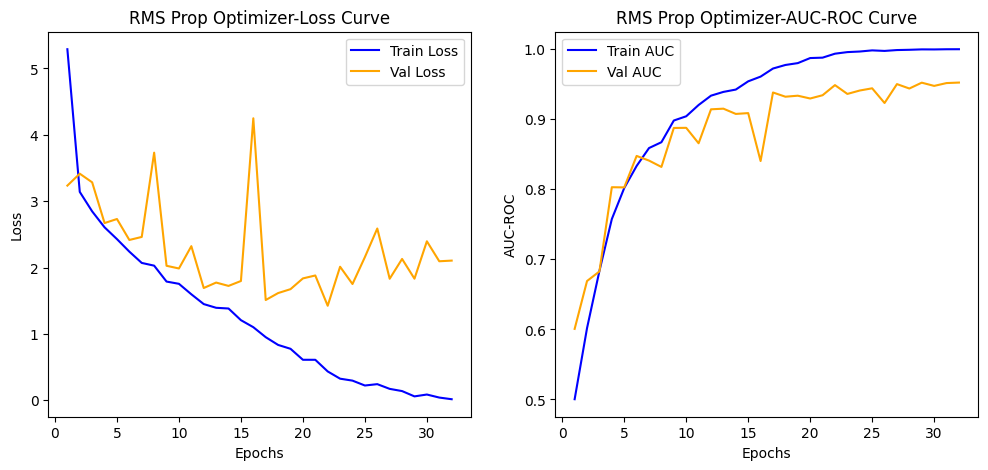

In [22]:
plot_training_curves(train_loss_rmsprop_list, val_loss_rmsprop_list, train_auc_rmsprop_list, val_auc_rmsprop_list, "RMS Prop Optimizer")

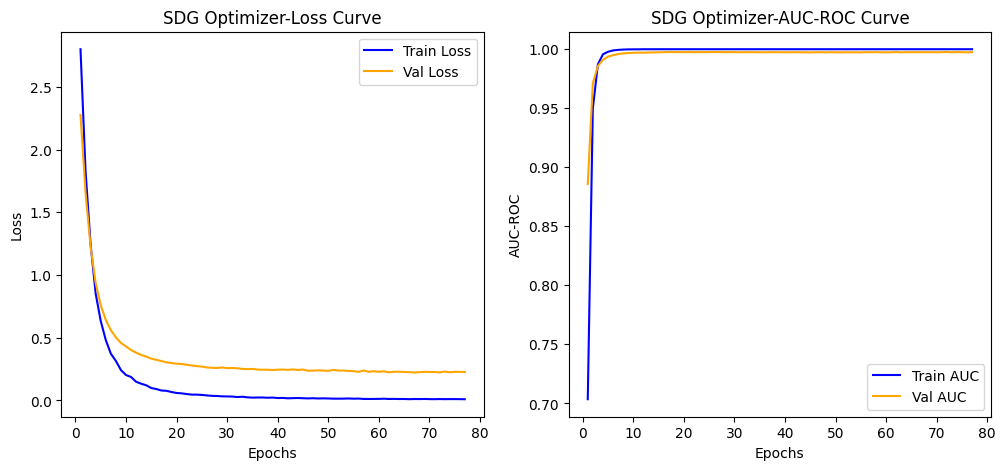

In [23]:
plot_training_curves(train_loss_sgd_list, val_loss_sgd_list, train_auc_sgd_list, val_auc_sgd_list, "SDG Optimizer")

# Model Results

In [24]:
def evaluate_model(model, test_loader, class_names, device):
    model.eval()  
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1) 
            preds = torch.argmax(probs, dim=1)
            all_test_preds.append(preds.cpu().numpy())  
            all_test_labels.append(labels.cpu().numpy())

    all_test_labels = np.concatenate(all_test_labels)
    all_test_preds = np.concatenate(all_test_preds)
    report = classification_report(all_test_labels, all_test_preds, target_names=class_names, digits=4)
    return report

In [25]:
report_adam = evaluate_model(resnet18_adam, test_loader, class_names, device)
print(report_adam)

                   precision    recall  f1-score   support

     agricultural     1.0000    0.8696    0.9302        23
         airplane     0.8696    0.9524    0.9091        21
  baseballdiamond     0.8333    0.8824    0.8571        17
            beach     0.9091    1.0000    0.9524        20
        buildings     0.5667    0.8500    0.6800        20
        chaparral     0.9474    1.0000    0.9730        18
 denseresidential     0.6875    0.4783    0.5641        23
           forest     0.9048    1.0000    0.9500        19
          freeway     0.7917    0.8636    0.8261        22
       golfcourse     0.7391    0.9444    0.8293        18
           harbor     1.0000    1.0000    1.0000        21
     intersection     0.7273    0.8421    0.7805        19
mediumresidential     0.4839    0.7895    0.6000        19
   mobilehomepark     0.9000    0.9000    0.9000        20
         overpass     0.9231    0.8571    0.8889        14
       parkinglot     1.0000    1.0000    1.0000       

In [26]:
report_adagrad = evaluate_model(resnet18_adagrad, test_loader, class_names, device)
print(report_adagrad)

                   precision    recall  f1-score   support

     agricultural     1.0000    0.8261    0.9048        23
         airplane     0.9130    1.0000    0.9545        21
  baseballdiamond     1.0000    1.0000    1.0000        17
            beach     0.9524    1.0000    0.9756        20
        buildings     0.8947    0.8500    0.8718        20
        chaparral     0.8571    1.0000    0.9231        18
 denseresidential     0.8077    0.9130    0.8571        23
           forest     0.9048    1.0000    0.9500        19
          freeway     0.9091    0.9091    0.9091        22
       golfcourse     1.0000    1.0000    1.0000        18
           harbor     1.0000    1.0000    1.0000        21
     intersection     1.0000    0.9474    0.9730        19
mediumresidential     0.9412    0.8421    0.8889        19
   mobilehomepark     1.0000    1.0000    1.0000        20
         overpass     0.9333    1.0000    0.9655        14
       parkinglot     1.0000    1.0000    1.0000       

In [27]:
report_adadelta = evaluate_model(resnet18_adadelta, test_loader, class_names, device)
print(report_adadelta)

                   precision    recall  f1-score   support

     agricultural     1.0000    0.9130    0.9545        23
         airplane     0.9545    1.0000    0.9767        21
  baseballdiamond     0.9444    1.0000    0.9714        17
            beach     1.0000    1.0000    1.0000        20
        buildings     0.7600    0.9500    0.8444        20
        chaparral     0.9474    1.0000    0.9730        18
 denseresidential     0.7895    0.6522    0.7143        23
           forest     0.9500    1.0000    0.9744        19
          freeway     1.0000    0.9545    0.9767        22
       golfcourse     0.9474    1.0000    0.9730        18
           harbor     0.9545    1.0000    0.9767        21
     intersection     0.9000    0.9474    0.9231        19
mediumresidential     0.7500    0.7895    0.7692        19
   mobilehomepark     0.9048    0.9500    0.9268        20
         overpass     0.9333    1.0000    0.9655        14
       parkinglot     1.0000    1.0000    1.0000       

In [28]:
report_rmsprop = evaluate_model(resnet18_rmsprop, test_loader, class_names, device)
print(report_rmsprop)

                   precision    recall  f1-score   support

     agricultural     1.0000    0.8696    0.9302        23
         airplane     0.8824    0.7143    0.7895        21
  baseballdiamond     0.8000    0.7059    0.7500        17
            beach     0.8261    0.9500    0.8837        20
        buildings     0.5000    0.6000    0.5455        20
        chaparral     0.8571    1.0000    0.9231        18
 denseresidential     0.5909    0.5652    0.5778        23
           forest     0.8261    1.0000    0.9048        19
          freeway     0.6087    0.6364    0.6222        22
       golfcourse     0.7143    0.8333    0.7692        18
           harbor     0.9545    1.0000    0.9767        21
     intersection     0.8750    0.3684    0.5185        19
mediumresidential     0.2941    0.2632    0.2778        19
   mobilehomepark     0.5862    0.8500    0.6939        20
         overpass     0.4211    0.5714    0.4848        14
       parkinglot     0.7857    0.8462    0.8148       

In [29]:
report_sgd = evaluate_model(resnet18_sgd, test_loader, class_names, device)
print(report_sgd)

                   precision    recall  f1-score   support

     agricultural     1.0000    0.9565    0.9778        23
         airplane     1.0000    1.0000    1.0000        21
  baseballdiamond     1.0000    0.9412    0.9697        17
            beach     0.9524    1.0000    0.9756        20
        buildings     0.7391    0.8500    0.7907        20
        chaparral     1.0000    1.0000    1.0000        18
 denseresidential     0.8500    0.7391    0.7907        23
           forest     0.9500    1.0000    0.9744        19
          freeway     1.0000    0.9091    0.9524        22
       golfcourse     0.9474    1.0000    0.9730        18
           harbor     1.0000    1.0000    1.0000        21
     intersection     0.9474    0.9474    0.9474        19
mediumresidential     0.7200    0.9474    0.8182        19
   mobilehomepark     0.9474    0.9000    0.9231        20
         overpass     0.8750    1.0000    0.9333        14
       parkinglot     1.0000    1.0000    1.0000       

# Loss function comparision

In [30]:
def extract_metrics(report):
    lines = report.split("\n")
    metrics = {}
    
    for line in lines:
        if "accuracy" in line:  # Extract accuracy
            metrics["accuracy"] = float(re.findall(r"\d+\.\d+", line)[0])
        elif "weighted avg" in line:  # Extract weighted avg precision, recall, f1-score
            values = re.findall(r"\d+\.\d+", line)
            metrics["precision"] = float(values[0])
            metrics["recall"] = float(values[1])
            metrics["f1-score"] = float(values[2])

    return metrics

metrics_sgd = extract_metrics(report_sgd)
metrics_adam = extract_metrics(report_adam)
metrics_adagrad = extract_metrics(report_adagrad)
metrics_adadelta = extract_metrics(report_adadelta)
metrics_rmsprop = extract_metrics(report_rmsprop)

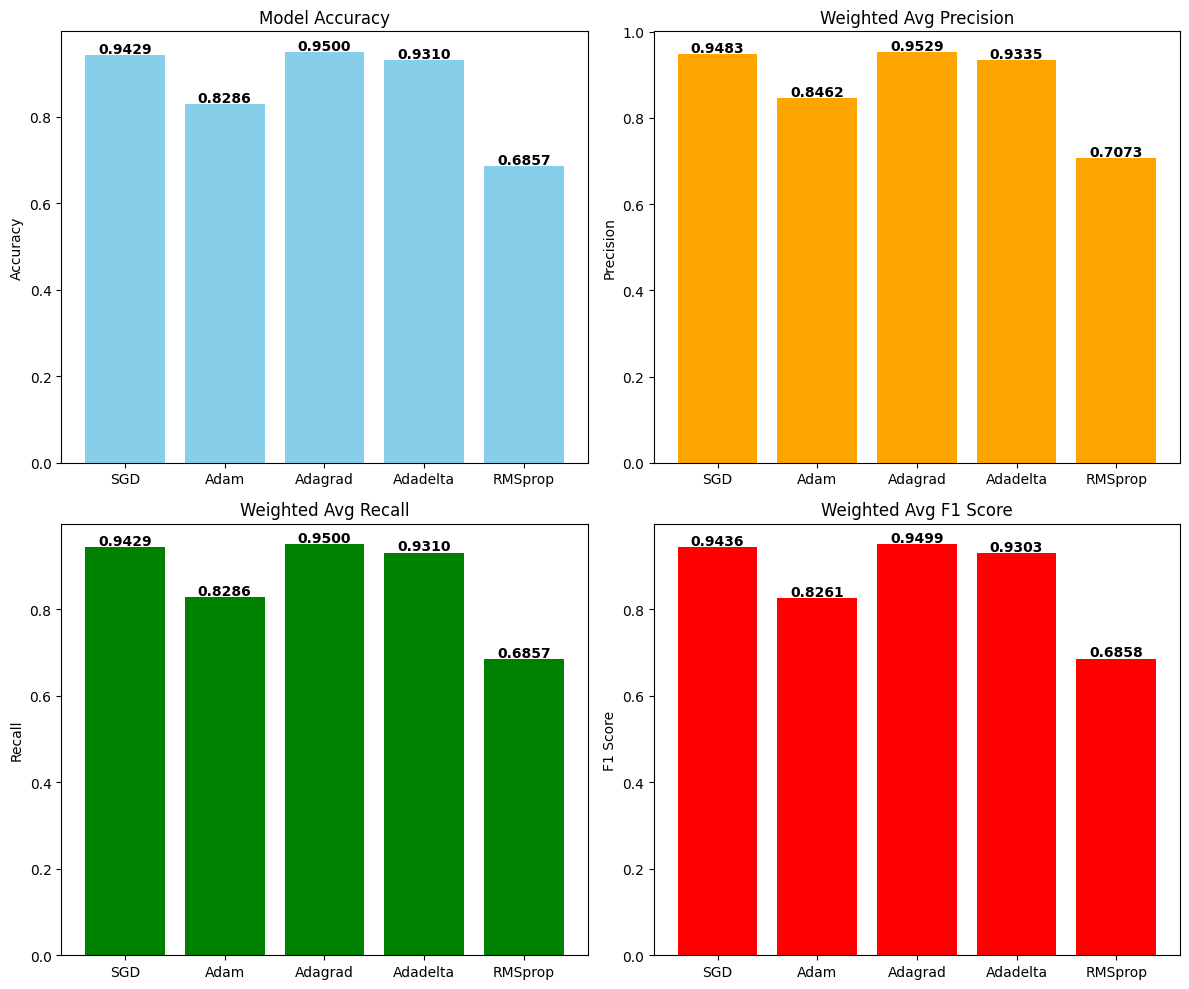

In [31]:
def add_value_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=10, fontweight='bold')

models = ["SGD", "Adam", "Adagrad", "Adadelta", "RMSprop"]
accuracy_values = [metrics_sgd["accuracy"], metrics_adam["accuracy"], metrics_adagrad["accuracy"], metrics_adadelta["accuracy"], metrics_rmsprop["accuracy"]]
precision_values = [metrics_sgd["precision"], metrics_adam["precision"], metrics_adagrad["precision"], metrics_adadelta["precision"], metrics_rmsprop["precision"]]
recall_values = [metrics_sgd["recall"], metrics_adam["recall"], metrics_adagrad["recall"], metrics_adadelta["recall"], metrics_rmsprop["recall"]]
f1_values = [metrics_sgd["f1-score"], metrics_adam["f1-score"], metrics_adagrad["f1-score"], metrics_adadelta["f1-score"], metrics_rmsprop["f1-score"]]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].bar(models, accuracy_values, color='skyblue')
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_ylabel("Accuracy")
add_value_labels(axes[0, 0], accuracy_values)

axes[0, 1].bar(models, precision_values, color='orange')
axes[0, 1].set_title("Weighted Avg Precision")
axes[0, 1].set_ylabel("Precision")
add_value_labels(axes[0, 1], precision_values)

axes[1, 0].bar(models, recall_values, color='green')
axes[1, 0].set_title("Weighted Avg Recall")
axes[1, 0].set_ylabel("Recall")
add_value_labels(axes[1, 0], recall_values)

axes[1, 1].bar(models, f1_values, color='red')
axes[1, 1].set_title("Weighted Avg F1 Score")
axes[1, 1].set_ylabel("F1 Score")
add_value_labels(axes[1, 1], f1_values)

plt.tight_layout()
plt.show()


In [32]:
print(0)

0
